# Titanic w/ Flax

I don't really know how to handle different datatypes properly in Jax/Flax. Let's look at the Titanic dataset to see if we can build a basic model.

In [1]:
from flax import linen as nn
from flax.metrics import tensorboard
from flax.training import train_state
import jax
import jax.numpy as jnp
import ml_collections
import numpy as np
import optax
import tensorflow_datasets as tfds
import pandas as pd

## Setting up the dataset

I'm using the version hosted on Kaggle here: https://www.kaggle.com/c/titanic/data

In [2]:
train_df = pd.read_csv('data/titanic/train.csv')
test_df = pd.read_csv('data/titanic/test.csv')
combine = [train_df, test_df]

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


```
survival - Survival (0 = No; 1 = Yes)
class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
name - Name
sex - Sex
age - Age
sibsp - Number of Siblings/Spouses Aboard
parch - Number of Parents/Children Aboard
ticket - Ticket Number
fare - Passenger Fare
cabin - Cabin
embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
boat - Lifeboat (if survived)
body - Body number (if did not survive and body was recovered)
```

So it looks like age and cabin are missing values...

## Exploration

Let's explore this dataset a little bit. Following: https://www.kaggle.com/startupsci/titanic-data-science-solutions

In [5]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [6]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


## Misc thoughts

### Completing

1. We want to complete `Age`
2. We want to complete `Embarked`

### Correcting

1. We want to drop `Ticket` (too many duplicates)
2. We want to drop `Cabin` (highly incomplete)
3. We want drop `PassengerId` (all unique)
4. We want to drop `Name` (likely little signal)

### Creating

1. We may want to create `Family` from `Parch` and `SibSp`
2. We may want to extract a "Title" from `Name`
3. We may want to create a new feature for Age bands
4. We may want to create a new feature for Fare bands

### Classifying

1. Women were most likely to have survived.
2. Children were more likely to have survived.
3. Upper-class passengers were more likely to have survived.



In [10]:
# Women were most likely to have survived
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [11]:
# PClass=1 were most likely to have survived
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [12]:
# Hard to say
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=True).mean().sort_values(by='SibSp', ascending=True)

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


<AxesSubplot:xlabel='SibSp'>

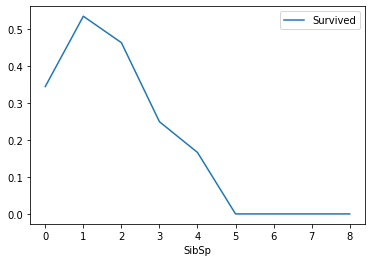

In [13]:
# Hard to say. Maybe "More than 1 sibling and there's a negative correlation"?
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=True).mean().sort_values(by='SibSp', ascending=True).plot()

### Visualizing Age

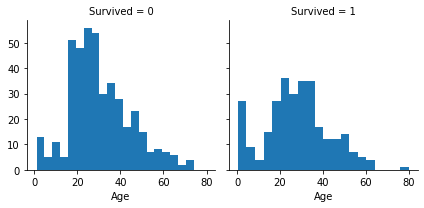

In [14]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

### Visualizing Pclass

/home/josh/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


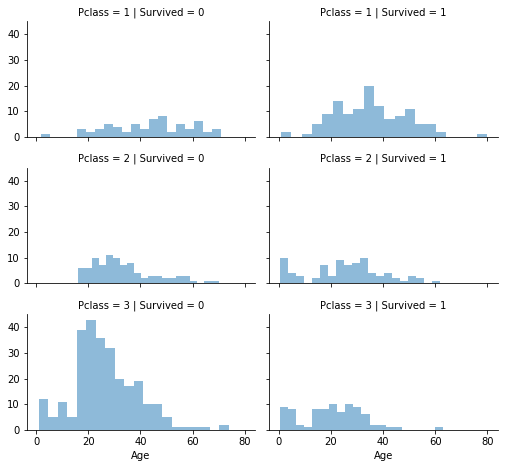

In [15]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

### Visualizing Embarked

Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

/home/josh/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/josh/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/josh/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


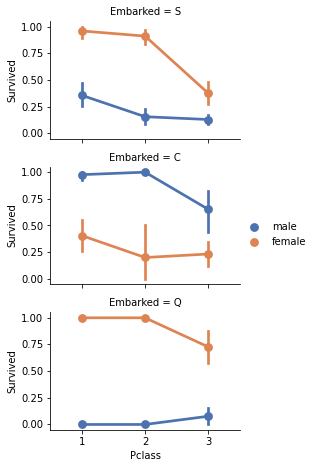

In [16]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

/home/josh/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/josh/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


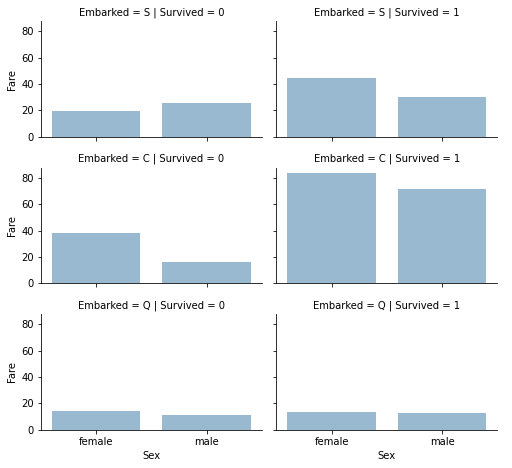

In [17]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

## Drop unused features

In [18]:
train_df = train_df.drop(columns=['Name', 'PassengerId', 'Ticket', 'Cabin'])
test_df = test_df.drop(['Name', 'PassengerId', 'Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

## Covert Sex from String to Categorical

In [19]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,S
1,1,1,1,38.0,1,0,71.2833,C
2,1,3,1,26.0,0,0,7.9250,S
3,1,1,1,35.0,1,0,53.1000,S
4,0,3,0,35.0,0,0,8.0500,S


## Completing Age with Median Values

/home/josh/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


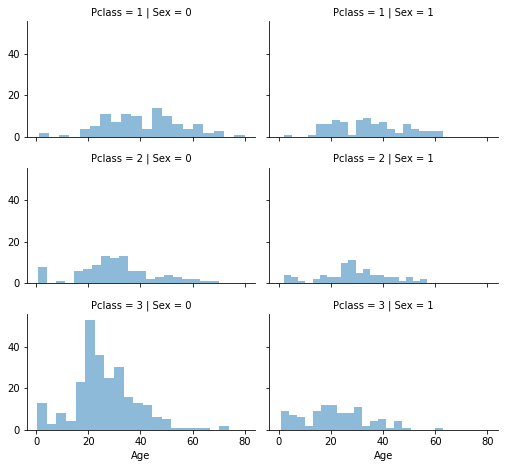

In [20]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [21]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [22]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22,1,0,7.2500,S
1,1,1,1,38,1,0,71.2833,C
2,1,3,1,26,0,0,7.9250,S
3,1,1,1,35,1,0,53.1000,S
4,0,3,0,35,0,0,8.0500,S


## Replace Age with "Age Bands"

In [23]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,1,1,0,7.2500,S
1,1,1,1,2,1,0,71.2833,C
2,1,3,1,1,0,0,7.9250,S
3,1,1,1,2,1,0,53.1000,S
4,0,3,0,2,0,0,8.0500,S


## Create "IsAlone" Feature

In [31]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


## Drop Parch and SibSp

In [32]:
train_df = train_df.drop(['Parch', 'SibSp'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone
0,0,3,0,1,7.2500,S,2,0
1,1,1,1,2,71.2833,C,2,0
2,1,3,1,1,7.9250,S,1,1
3,1,1,1,2,53.1000,S,2,0
4,0,3,0,2,8.0500,S,1,1


## Convert Embarked to Numeric

In [43]:
# Find most frequent departing port
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [44]:
# Replace 2 missing values with the most frequent departing port
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

In [46]:
# none missing
train_df['Embarked'].value_counts().sum()

891

In [47]:
# Now things are pretty much ready to go.
train_df

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone
0,0,3,0,1,7.2500,S,2,0
1,1,1,1,2,71.2833,C,2,0
2,1,3,1,1,7.9250,S,1,1
3,1,1,1,2,53.1000,S,2,0
4,0,3,0,2,8.0500,S,1,1
...,...,...,...,...,...,...,...,...
886,0,2,0,1,13.0000,S,1,1
887,1,1,1,1,30.0000,S,1,1
888,0,3,1,1,23.4500,S,4,0
889,1,1,0,1,30.0000,C,1,1


In [51]:
# Save and we're ready to model!
train_df.to_csv('data/titanic/train_clean.csv', index=False)
test_df.to_csv('data/titanic/test_clean.csv', index=False)